<a href="https://colab.research.google.com/github/solaemanachmad/mti_2023/blob/main/scoring_fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import itertools
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Pre-Processing Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MTI/SMT2/TIF226203 - Sistem Cerdas/uts/dataset/stocks.csv')

In [ ]:
def weighted_average(group, cols):
    years = group['Year'].values
    latest_year = max(years)
    weights = [len(years) - (latest_year - year) for year in years]
    weighted_avgs = {}
    for col in cols:
        weighted_sum = sum(group[col] * weights)
        total_weights = sum(weights)
        weighted_avg = weighted_sum / total_weights
        weighted_avgs[col] = weighted_avg
    return pd.Series(weighted_avgs)
cols_to_average = ['PER', 'DER', 'PBV', 'CR']
weighted_data = data.groupby('Stock').apply(lambda x: weighted_average(x, cols_to_average))

In [ ]:
print (weighted_data)

             PER       DER        PBV        CR
Stock                                          
ADES    8.641333  0.604667   1.189333  2.520667
AISA    0.920667  0.078000  29.530667  0.595333
BUDI   12.705333  1.462000   0.374667  1.051333
CEKA    6.102667  0.292667   0.853333  4.300667
DLTA   19.452667  0.182667   3.735333  4.398667
DVLA   13.156667  0.444000   1.936667  2.605333
GGRM   13.158000  0.478667   2.292000  2.249333
HMSP   26.026000  0.580000   9.204667  2.813333
ICBP   23.292667  1.183333   4.843333  2.301333
INDF   11.508667  1.513333   1.369333  1.307333
KINO   24.953333  0.809333   1.711333  1.378667
KLBF   28.170667  0.237333   4.767333  4.338667
MLBI   41.169333  1.338000  23.723333  0.797333
MYOR   27.872667  0.926667   5.636667  3.140000
PYFA   16.657333  0.504667   1.690000  3.085333
ROTI   42.388000  0.509333   2.870667  2.665333
SIDO   21.734667  0.150667   5.603333  4.754667
SKLT   26.397333  1.026000   2.558667  1.353333
STTP   18.822667  0.474000   3.708667  2

In [ ]:
statistics = weighted_data.describe().loc[['mean', 'std', 'min', 'max']]
statistics.loc['std min'] = statistics.loc['mean'] - statistics.loc['std']
statistics.loc['std max'] = statistics.loc['mean'] + statistics.loc['std']

new_index_order = ['mean', 'std', 'min', 'std min', 'std max', 'max']
statistics = statistics.reindex(new_index_order)
headers = ["Statistics", "PER", "DER", "PBV", "CR" ]

statistics = statistics.round(2)

print(tabulate(statistics, headers=headers))

Statistics      PER    DER    PBV    CR
------------  -----  -----  -----  ----
mean          20.26   0.7    7.37  2.8
std           12.06   0.6   13.16  1.59
min            0.92   0.08   0.37  0.6
std min        8.2    0.11  -5.79  1.21
std max       32.32   1.3   20.52  4.39
max           43.37   2.7   59.68  7.01


# Himpunan Fuzzy

In [ ]:
from tabulate import tabulate

def create_fuzzy_params(mean, std, min, max):
    if mean - std < min or mean + std > max:
        std = std / 2
    L = [0, 0, round(min, 2), round(mean - std, 2)]
    M = [round(min, 2), round(mean - std, 2), round(mean + std, 2), round(max, 2)]
    b = round(mean + std + max_val)
    H = [round(mean + std, 2), round(max, 2), b, b]
    return L, M, H

fuzzy_params = {}
for attr, values in statistics.items():
    mean = values['mean']
    std = values['std']
    min_val = values['min']
    max_val = values['max']
    fuzzy_params[attr] = create_fuzzy_params(mean, std, min_val, max_val)

headers = ["Attribute", "L", "M", "H"]
fuzzy_numbers = []
for attr, params in fuzzy_params.items():
    fuzzy_numbers.append([attr, params[0], params[1], params[2]])

print(tabulate(fuzzy_numbers, headers=headers))

Attribute    L                   M                           H
-----------  ------------------  --------------------------  ----------------------
PER          [0, 0, 0.92, 8.2]   [0.92, 8.2, 32.32, 43.37]   [32.32, 43.37, 76, 76]
DER          [0, 0, 0.08, 0.1]   [0.08, 0.1, 1.3, 2.7]       [1.3, 2.7, 4, 4]
PBV          [0, 0, 0.37, 0.79]  [0.37, 0.79, 13.95, 59.68]  [13.95, 59.68, 74, 74]
CR           [0, 0, 0.6, 1.21]   [0.6, 1.21, 4.39, 7.01]     [4.39, 7.01, 11, 11]


# Fuzzy Rules

In [ ]:
per_min = fuzzy_numbers[0][1][2]
per_meanminussd = fuzzy_numbers[0][2][1]
per_meanplussd = fuzzy_numbers[0][3][0]
per_max = fuzzy_numbers[0][3][1]
per_limit = fuzzy_numbers[0][3][3]

der_min = fuzzy_numbers[1][1][2]
der_meanminussd = fuzzy_numbers[1][2][1]
der_meanplussd = fuzzy_numbers[1][3][0]
der_max = fuzzy_numbers[1][3][1]
der_limit = fuzzy_numbers[1][3][3]

pbv_min = fuzzy_numbers[2][1][2]
pbv_meanminussd = fuzzy_numbers[2][2][1]
pbv_meanplussd = fuzzy_numbers[2][3][0]
pbv_max = fuzzy_numbers[2][3][1]
pbv_limit = fuzzy_numbers[2][3][3]

cr_min = fuzzy_numbers[3][1][2]
cr_meanminussd = fuzzy_numbers[3][2][1]
cr_meanplussd = fuzzy_numbers[3][3][0]
cr_max = fuzzy_numbers[3][3][1]
cr_limit = fuzzy_numbers[3][3][3]

In [ ]:
import itertools

linguistic_terms = {
    'PER': {'L': 1, 'M': 0.5, 'H': 0},
    'PBV': {'L': 1, 'M': 0.5, 'H': 0},
    'DER': {'L': 0, 'M': 0.5, 'H': 1},
    'CR': {'L': 0, 'M': 0.5, 'H': 1},
}

linguistic_combinations = list(itertools.product(*linguistic_terms.values()))

rules = []
for i, combination in enumerate(linguistic_combinations, start=1):
    rule = {'Rule': i}
    for j, attribute in enumerate(linguistic_terms.keys()):
        rule[attribute] = combination[j]

    w_score = sum(linguistic_terms[attribute][rule[attribute]] for attribute in linguistic_terms.keys()) / len(linguistic_terms)
    rule['W'] = w_score

    if w_score < 0.2:
        rule['Score'] = 'L'
    elif 0.2 <= w_score < 0.4:
        rule['Score'] = 'RL'
    elif 0.4 <= w_score <= 0.6:
        rule['Score'] = 'M'
    elif 0.6 <= w_score < 0.8:
        rule['Score'] = 'RH'
    else:
        rule['Score'] = 'H'

    rules.append(rule)

rules_df = pd.DataFrame(rules)

print(tabulate(rules_df, headers='keys', tablefmt='github'))

|    |   Rule | PER   | PBV   | DER   | CR   |     W | Score   |
|----|--------|-------|-------|-------|------|-------|---------|
|  0 |      1 | L     | L     | L     | L    | 0.5   | M       |
|  1 |      2 | L     | L     | L     | M    | 0.625 | RH      |
|  2 |      3 | L     | L     | L     | H    | 0.75  | RH      |
|  3 |      4 | L     | L     | M     | L    | 0.625 | RH      |
|  4 |      5 | L     | L     | M     | M    | 0.75  | RH      |
|  5 |      6 | L     | L     | M     | H    | 0.875 | H       |
|  6 |      7 | L     | L     | H     | L    | 0.75  | RH      |
|  7 |      8 | L     | L     | H     | M    | 0.875 | H       |
|  8 |      9 | L     | L     | H     | H    | 1     | H       |
|  9 |     10 | L     | M     | L     | L    | 0.375 | RL      |
| 10 |     11 | L     | M     | L     | M    | 0.5   | M       |
| 11 |     12 | L     | M     | L     | H    | 0.625 | RH      |
| 12 |     13 | L     | M     | M     | L    | 0.5   | M       |
| 13 |     14 | L     | M

# Inference of Fuzzy Rules

In [ ]:
per_low = fuzz.trapmf(np.arange(0, per_limit, 1), [0, 0, per_min, per_meanminussd])
per_mid = fuzz.trapmf(np.arange(0, per_limit, 1), [per_min, per_meanminussd, per_meanplussd, per_max])
per_high = fuzz.trapmf(np.arange(0, per_limit, 1), [per_meanplussd, per_max, per_limit, per_limit])

pbv_low = fuzz.trapmf(np.arange(0, pbv_limit, 0.01), [0, 0, pbv_min, pbv_meanminussd])
pbv_mid = fuzz.trapmf(np.arange(0, pbv_limit, 0.01), [pbv_min, pbv_meanminussd, pbv_meanplussd, pbv_max])
pbv_high = fuzz.trapmf(np.arange(0, pbv_limit, 0.01), [pbv_meanplussd,pbv_max, pbv_limit, pbv_limit])

der_low = fuzz.trapmf(np.arange(0, der_limit, 0.01), [0, 0, der_min, pbv_meanminussd])
der_mid = fuzz.trapmf(np.arange(0, der_limit, 0.01), [der_min, der_meanminussd, der_meanplussd, der_max])
der_high = fuzz.trapmf(np.arange(0, der_limit, 0.01), [der_meanplussd, der_max, der_limit, der_limit])

cr_low = fuzz.trapmf(np.arange(0, cr_limit, 0.01), [0, 0, cr_min, cr_meanminussd])
cr_mid = fuzz.trapmf(np.arange(0, cr_limit, 0.01), [cr_min, cr_meanminussd, cr_meanplussd, cr_max])
cr_high = fuzz.trapmf(np.arange(0, cr_limit, 0.01), [cr_meanplussd, cr_max, cr_limit, cr_limit])

In [ ]:

def score_per(per):
    if per <= per_min:
        return 0
    elif per >= per_max:
        return 1
    else:
        return (per - per_min) / (per_max - per_min)

def score_pbv(pbv):
    if pbv <= pbv_min:
        return 1
    elif pbv >= pbv_max:
        return 0
    else:
        return (pbv_max - pbv) / (pbv_max - pbv_min)

def score_der(der):
    if der <= der_min:
        return 1
    elif der >= der_max:
        return 0
    else:
        return (der_max - der) / (der_max - der_min)

def score_cr(cr):
    if cr <= cr_min:
        return 0
    elif cr >= cr_max:
        return 1
    else:
        return (cr - cr_min) / (cr_max - cr_min)

# Defuzzyfication and Testing

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/MTI/SMT2/TIF226203 - Sistem Cerdas/uts/dataset/test_data.csv')

test_data['W'] = (test_data['PER'].apply(score_per) + test_data['DER'].apply(score_der) + test_data['PBV'].apply(score_pbv) + test_data['CR'].apply(score_cr)) / 4
print(test_data)

   Stock    PER   DER    PBV    CR         W
0   ADES  19.77  0.01   2.46  7.42  0.852203
1   AISA  60.50  0.31   1.17  0.75  0.730532
2   BUDI  13.91  0.91   0.82  1.33  0.523878
3   CEKA   8.37  0.00   0.66  4.46  0.693199
4   DLTA  12.87  0.00   2.75  4.89  0.727662
5   DVLA  10.88  0.05   1.13  2.71  0.637747
6   GGRM   8.77  0.20   0.56  1.85  0.582732
7   HMSP  11.02  0.02   2.81  1.88  0.599119
8   ICBP  23.37  1.04   2.92  3.68  0.649988
9   INDF   8.10  1.18   0.88  1.87  0.484705
10  KINO  28.36  1.21   1.29  0.80  0.557700
11  KLBF  23.69  0.03   3.04  4.31  0.767540
12  MLBI  12.98  0.25   8.68  1.07  0.538106
13  MYOR  14.81  0.27   3.28  3.57  0.667241
14  PYFA  -0.44  4.49   0.17  2.92  0.340484
15  ROTI  19.19  0.21   2.78  1.10  0.604535
16  SIDO  20.61  0.00   5.66  5.91  0.800760
17  SKLT  11.27  0.30   1.42  2.11  0.594428
18  STTP  14.95  0.00   2.85  6.95  0.819833
19  TCID  80.20  0.00   0.54  9.61  0.999283
20  TSPC   8.83  0.16   1.11  2.75  0.619685
21  ULTJ  

In [ ]:
df = pd.DataFrame(test_data)
total_weights = df['W'].sum()
df['Normal Weight'] = df['W']/total_weights
df['Normal Weight'] = df['Normal Weight'].round(4)
sorted_df = df.sort_values(by='W', ascending=False).reset_index(drop=True)
sorted_df['Ranking'] = df.index + 1
print(sorted_df)

   Stock    PER   DER    PBV    CR         W  Normal Weight  Ranking
0   TCID  80.20  0.00   0.54  9.61  0.999283         0.0634        1
1   ADES  19.77  0.01   2.46  7.42  0.852203         0.0541        2
2   STTP  14.95  0.00   2.85  6.95  0.819833         0.0520        3
3   ULTJ  17.23  0.00   3.00  6.28  0.806497         0.0512        4
4   SIDO  20.61  0.00   5.66  5.91  0.800760         0.0508        5
5   KLBF  23.69  0.03   3.04  4.31  0.767540         0.0487        6
6   AISA  60.50  0.31   1.17  0.75  0.730532         0.0464        7
7   DLTA  12.87  0.00   2.75  4.89  0.727662         0.0462        8
8   CEKA   8.37  0.00   0.66  4.46  0.693199         0.0440        9
9   MYOR  14.81  0.27   3.28  3.57  0.667241         0.0424       10
10  ICBP  23.37  1.04   2.92  3.68  0.649988         0.0413       11
11  DVLA  10.88  0.05   1.13  2.71  0.637747         0.0405       12
12  WIIM   5.12  0.06   1.25  3.26  0.624770         0.0397       13
13  TSPC   8.83  0.16   1.11  2.75

In [ ]:
def get_score(w):
    if w >= 0.8:
        return 'H'
    elif w >= 0.6:
        return 'RH'
    elif w >= 0.4:
        return 'M'
    elif w >= 0.2:
        return 'RL'
    else:
        return 'L'

sorted_df['Score'] = sorted_df['W'].apply(get_score)

print(sorted_df)

   Stock    PER   DER    PBV    CR         W  Normal Weight  Ranking Score
0   TCID  80.20  0.00   0.54  9.61  0.999283         0.0634        1     H
1   ADES  19.77  0.01   2.46  7.42  0.852203         0.0541        2     H
2   STTP  14.95  0.00   2.85  6.95  0.819833         0.0520        3     H
3   ULTJ  17.23  0.00   3.00  6.28  0.806497         0.0512        4     H
4   SIDO  20.61  0.00   5.66  5.91  0.800760         0.0508        5     H
5   KLBF  23.69  0.03   3.04  4.31  0.767540         0.0487        6    RH
6   AISA  60.50  0.31   1.17  0.75  0.730532         0.0464        7    RH
7   DLTA  12.87  0.00   2.75  4.89  0.727662         0.0462        8    RH
8   CEKA   8.37  0.00   0.66  4.46  0.693199         0.0440        9    RH
9   MYOR  14.81  0.27   3.28  3.57  0.667241         0.0424       10    RH
10  ICBP  23.37  1.04   2.92  3.68  0.649988         0.0413       11    RH
11  DVLA  10.88  0.05   1.13  2.71  0.637747         0.0405       12    RH
12  WIIM   5.12  0.06   1

In [ ]:
df_h = pd.DataFrame(sorted_df)
df_h = df_h[df_h['Score'] == 'H']
total_weight_h = df_h['W'].sum()

df_h['Weight'] = total_weight_h
df_h['Weight of Weighted Stock'] = df_h['W'] / total_weight_h
total_weighted_stock_weight = df_h['Weight of Weighted Stock'].sum()
df_h['Prosentase'] = (df_h['Weight of Weighted Stock'] * 100).round(2).astype(str) + '%'

total_row = pd.DataFrame({
    'Stock': ['Total'],
    'Weight': [total_weight_h],
    'Weight of Weighted Stock': [total_weighted_stock_weight],
    'Prosentase': [total_weighted_stock_weight * 100],
    'Ranking': [''],
    'Score': ['']
}, index=[0])

df_h = pd.concat([df_h, total_row])

print(df_h[['Stock', 'Weight', 'Weight of Weighted Stock', 'Prosentase', 'Ranking', 'Score']])

   Stock    Weight  Weight of Weighted Stock Prosentase Ranking Score
0   TCID  4.278577                  0.233555     23.36%       1     H
1   ADES  4.278577                  0.199179     19.92%       2     H
2   STTP  4.278577                  0.191613     19.16%       3     H
3   ULTJ  4.278577                  0.188497     18.85%       4     H
4   SIDO  4.278577                  0.187156     18.72%       5     H
0  Total  4.278577                  1.000000      100.0              


# Visualization

In [ ]:
def RangeSub (_low, _high, _step):
  subjective = np.arange(_low, _high, _step)
  return subjective

def LinguisticTerm(_rule, _range_subjective, _title):
  lo = fuzz.trapmf(_range_subjective, _rule[0])
  mi = fuzz.trapmf(_range_subjective, _rule[1])
  hi = fuzz.trapmf(_range_subjective, _rule[2])

  fig, ax = plt.subplots(nrows=1, figsize=(6,3))
  ax.plot(_range_subjective, lo, 'b', linewidth=1.5, label ="Low")
  ax.plot(_range_subjective, mi, 'g', linewidth=1.5, label ="Mid")
  ax.plot(_range_subjective, hi, 'r', linewidth=1.5, label ="High")

  ax.set_title(_title)
  ax.legend()

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.get_xaxis().tick_bottom()
  ax.get_yaxis().tick_left()

  plt.tight_layout()
  plt.show()

  return lo, mi, hi

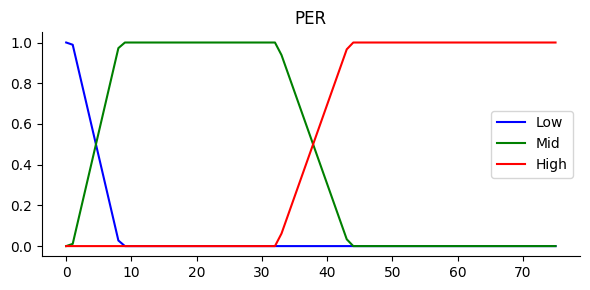

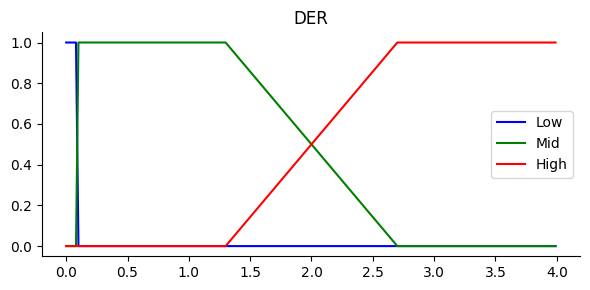

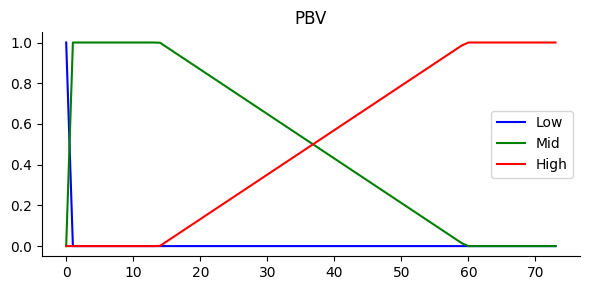

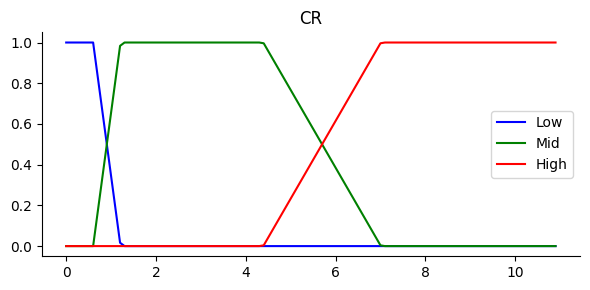

In [ ]:
xpe = RangeSub (0, 76, 1)
rpe = np.array([
    [0, 0, 0.92, 8.2],
    [0.92, 8.2, 32.32, 43.37],
    [32.32, 43.37, 76, 76]
])
lo_pe, mi_pe, hi_pe = LinguisticTerm(rpe, xpe, 'PER')

xder = RangeSub (0, 4, 0.01)
rder = np.array([
    [0, 0, 0.08, 0.1],
    [0.08, 0.1, 1.3, 2.7],
    [1.3, 2.7, 4, 4]
])
lo_der, mi_der, hi_der = LinguisticTerm(rder, xder, 'DER')

xpbv = RangeSub (0, 74, 1)
rpbv = np.array([
    [0, 0, 0.37, 0.79],
    [0.37, 0.79, 13.95, 59.68],
    [13.95, 59.68, 74, 74]
])
lo_pbv, mi_pbv, hi_pbv = LinguisticTerm(rpbv, xpbv, 'PBV')

xcr = RangeSub (0, 11, 0.1)
rcr = np.array([
    [0, 0, 0.6, 1.21],
    [0.6, 1.21, 4.39, 7.01],
    [4.39, 7.01, 11, 11]
])
lo_cr, mi_cr, hi_cr = LinguisticTerm(rcr, xcr, 'CR')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
vis = sorted_df['W']

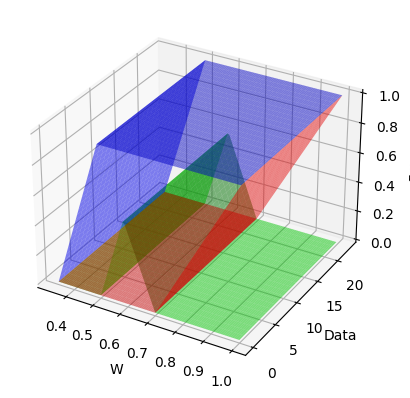

In [ ]:
w_min = min(vis)
w_max = max(vis)

def fuzzy_membership(w, a, b, c):
    low = np.maximum(0, np.minimum((w - a) / (b - a), 1))
    medium = np.maximum(0, np.minimum((c - w) / (c - b), (w - b) / (b - a)))
    high = np.maximum(0, np.minimum((w - c) / (w_max - c), 1))
    return low, medium, high

x = np.linspace(w_min, w_max, 100)
y = np.arange(len(vis))
X, Y = np.meshgrid(x, y)
Z_low, Z_medium, Z_high = fuzzy_membership(X, w_min, 0.5, 0.7)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(Z_low), rstride=1, cstride=1, color=np.array([0, 0, 1, 0.5]), label='L')
ax.plot_surface(X, Y, np.array(Z_medium), rstride=1, cstride=1, color=np.array([0, 1, 0, 0.5]), label='M')
ax.plot_surface(X, Y, np.array(Z_high), rstride=1, cstride=1, color=np.array([1, 0, 0, 0.5]), label='L')
ax.set_xlabel('W')
ax.set_ylabel('Data')
ax.set_zlabel('Fuzzy')
plt.show()